# Computer Vision - Project
imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import h5py
import requests
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import tensorflow as tf
import h5py, requests, os
import matplotlib.patches as patches

In [2]:
# IMG_SIZE = (64, 64)
# IMG_SHAPE = IMG_SIZE + (3,)
# base_model = tf.keras.applications.resnet(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')
# base_model.trainable = False

Constants

In [3]:
#ZIP_PATH = "https://drive.google.com/drive/folders/1jzHYpTwywUYA53nMGHVROSuVO14hEueq?usp=sharing/"
FILE_NAME ="SynthText_train.h5"
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
tf.keras.backend.clear_session()


In [4]:
def sort_points(points, center):
    # calculate the angle of each point from the center point
    angles = np.arctan2(points[:, 1] - center[1], points[:, 0] - center[0])
    # sort the points by angle
    sorted_points = points[np.argsort(angles)]
    return sorted_points

In [5]:
def draw_points(image, points, color=(255, 0, 0), radius=3):
    # create a copy of the image
    img = image.copy()
    # iterate over the points and draw them on the image
    for point in points:
        cv2.circle(img, tuple(map(int, point)), radius, color, -1)
    return img


In [6]:
def get_bb(img, bbs, indx):
    x1 = int(bbs[0,0,indx])
    y1 = int(bbs[1,0,indx])
    x2 = int(bbs[0,1,indx])
    y2 = int(bbs[1,1,indx])
    x3 = int(bbs[0,2,indx])
    y3 = int(bbs[1,2,indx])
    x4 = int(bbs[0,3,indx])
    y4 = int(bbs[1,3,indx])
    # calculate bounding rectangle
    top_left_x = max(0, min([x1,x2,x3,x4]))
    top_left_y = max(0, min([y1,y2,y3,y4]))
    bot_right_x = max(0, max([x1,x2,x3,x4]))
    bot_right_y = max(0, max([y1,y2,y3,y4]))
    # points = np.float32([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
    
    # create an empty image with the same shape as the input image
    # mask = np.zeros_like(img[:,:,0])
    # create a list of the bounding box points in the correct format
    # bounding_box = np.array([points], dtype=np.int32)
    # fill the area inside the bounding box with white
    # cv2.fillPoly(mask, bounding_box, 255)
    # apply the mask to the image
    ####res = cv2.bitwise_and(img, mask)
    # try1 = np.array(np.where(mask == 255, 255, 0), dtype=np.uint8)
    # print(x)
    # inv_mask = cv2.bitwise_not(mask)
    # res2 = cv2.bitwise_and(img, inv_mask)
    # bb2 = np.int32([[top_left_x, bot_right_y], [bot_right_x, bot_right_y],[bot_right_x,top_left_y], [top_left_x,top_left_y]])
    # print(bb2)
    # mask2 = np.zeros_like(img)
    # # bb2 = np.array(frame, dtype=np.int32)
    # cv2.fillPoly(mask2, bb2, (255, 255, 255))
    # mask = mask[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]
    res = img[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]

    #res = img[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]
    #flipping
    """"if(x2 < x1):
        res = cv2.flip(res, 1)
    if(y2 < y1):
        res = cv2.flip(res, 0)
    plt.imshow(mask)
    plt.show()
    print(mask.shape)"""
    return res

In [7]:
def font_to_num(font):
    if font == b'Alex Brush':
        return 0
    elif font == b'Titillium Web':
        return 1
    elif font == b'Sansation':
        return 2
    elif font == b'Open Sans':
        return 3
    else:
        return 4

In [8]:

# def prepare_img(img, bbs, index, size):
#     cropped, mask = get_bb(img, bbs, index)
#     cropped = cv2.GaussianBlur(np.array(cropped), (3, 3), 0)
#     # plt.imshow(cropped)
#     # plt.show()
#     # cropped = tf.image.convert_image_dtype(cropped, tf.float32)
    
#     cropped = tf.cast(cropped, tf.int32)
#     # plt.imshow(cropped)
#     # plt.show()
#     # gray_mask = tf.image.rgb_to_grayscale(mask)
#     # print(mask.shape)
#     # print(cropped.shape)
#     cropped = tf.image.rgb_to_grayscale(cropped)
#     cropped = tf.cast(cropped, tf.float32)
    
#     # print(cropped.shape)
#     cropped = tf.expand_dims(cropped, 0)
#     mask = tf.expand_dims(mask, 2)
#     # mask = tf.image.resize_with_pad(mask, size, size)
#     # print(cropped.shape)
#     # print(cropped.shape)
#     cropped = tf.image.sobel_edges(cropped)
#     cropped = cropped**2
#     # print(cropped.shape)
#     cropped = tf.math.reduce_sum(cropped,axis=-1) # sum all magnitude components
#     cropped = tf.sqrt(cropped) # this is the image tensor you want
#     # print(cropped[0, :, :, :].shape)
#     # plt.imshow(cropped[0, :, :, :], cmap='gray')
#     # plt.show()
#     cropped = cropped[0, :, :, :]
#     # plt.imshow(cropped, cmap ='gray')
#     # plt.show()
#     # plt.imshow(mask, cmap ='gray')
#     # plt.show()
#     # print(cropped.shape)
#     # print(gray_mask.shape)
# #    cropped = tf.cast(cropped, tf.int32)
# #    mask = tf.cast(mask, tf.int32)
#     # print(gray_mask)
#     # res = tf.multiply(cropped, mask)
    
#     # plt.imshow(mask, cmap ='gray')
#     # plt.show()
#     cropped = tf.image.resize_with_pad(cropped, size, size)
#     # plt.imshow(cropped, cmap ='gray')
#     # plt.show()
    
#     return cropped#res
#     # blurred = cv2.GaussianBlur(cropped,(3,3),0)
#     # gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY).squeeze().astype(np.uint8)
#     # gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY).squeeze().astype(np.uint8)
#     # img_laplacian = cv2.Laplacian(np.array(gray),cv2.CV_8U)
#     # res = cv2.bitwise_and(img_laplacian, gray_mask)
#     # res = cv2.resize(res, (64,64),interpolation = cv2.INTER_AREA)
#     # return res.reshape((64,64,1))

In [9]:
def prepare_img(img, bbs, index, size):
    cropped = get_bb(img, bbs, index)
    
    cropped = tf.image.resize(cropped, (size, size), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    cropped = tf.image.rgb_to_grayscale(cropped)
    # print(cropped.shape)
    cropped = tf.image.convert_image_dtype(cropped, tf.float32)
    # plt.imshow(cropped, cmap='gray')
    # plt.show()
    return cropped

In [10]:
def get_data_set(size: int):
    db = h5py.File(FILE_NAME, 'r')
    im_names = list(db['data'].keys())
    train_x = []
    train_y = []
    for i in range(0, len(im_names)-1):
        im = im_names[i]
        img  = db['data'][im][:]
        fonts = db['data'][im].attrs['font']
        txts = db['data'][im].attrs['txt']
        charBBs = db['data'][im].attrs['charBB']
        wordBBs = db['data'][im].attrs['wordBB']
        font_indx = 0 
        char_indx = 0
        # print(im)
        for j in range(0, len(txts)):
            cropped = prepare_img(img, wordBBs, j, size)
            train_x.append(cropped)
            train_y.append(font_to_num(fonts[font_indx]))
            font_indx += len(txts[j])
            #plt.imshow(cropped)
            #plt.show()
            for k in range(0, len(txts[j])):
                cropped = prepare_img(img, charBBs, char_indx, size)
                train_x.append(cropped)
                train_y.append(font_to_num(fonts[char_indx]))
                char_indx+=1
                #plt.imshow(cropped)
                #plt.show()
    return train_x, train_y

In [11]:
SIZE=128
train_x, train_y = get_data_set(SIZE)

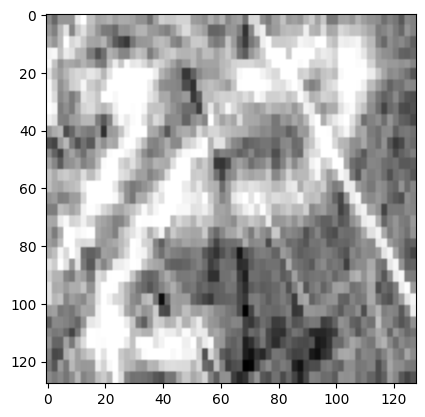

In [12]:
train_X = np.asarray(train_x, dtype="float") / 255.0
plt.imshow(train_x[3], cmap='gray')
# print(train_x)

In [13]:
#cut the set for train and validation
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [14]:
Y_train = np_utils.to_categorical(y_train, 5)
Y_test = np_utils.to_categorical(y_test, 5)

In [15]:
X_train = np.array(x_train)
Y_train = np.array(Y_train)
# print(X_train.shape)
# print(Y_train.shape)
# plt.imshow(X_train[2], cmap='gray')


In [182]:
from keras.preprocessing.image import ImageDataGenerator
def data_augmentation(X, Y):
    datagen =  ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=10, fill_mode='reflect', shear_range=10)
    it = datagen.flow(X, Y, batch_size=10)
    return it, datagen

In [183]:
it, datagen = data_augmentation(X_train, Y_train)

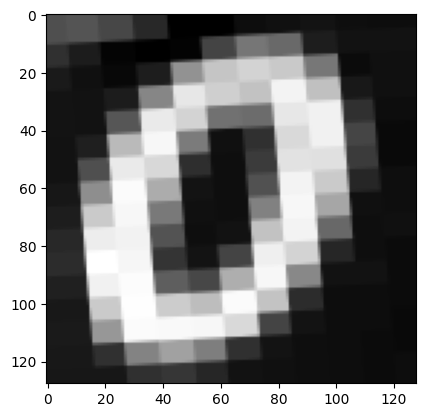

In [184]:
img, label = it.next()
# print(img)
plt.imshow(img[0], cmap = 'gray')
plt.show()

In [219]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import LSTM
from keras.layers import Resizing
# SIZE=100
visible = Input(shape=(SIZE,SIZE,1))
conv = Conv2D(32, kernel_size=4, activation='relu')(visible)
pool = MaxPooling2D(pool_size=(2, 2))(conv)
x = Dropout(0.25)(pool)
conv = Conv2D(32, kernel_size=4, activation='relu')(x)
pool = MaxPooling2D(pool_size=(2, 2))(conv)
x = Dropout(0.25)(pool)
conv = Conv2D(64, kernel_size=4, activation='relu')(x)
pool = MaxPooling2D(pool_size=(2, 2))(conv)
# x = Dropout(0.25)(pool)
# conv = Conv2D(31, kernel_size=4, activation='relu')(x)
# pool = MaxPooling2D(pool_size=(2, 2))(conv)
# x = Dropout(0.25)(pool)
# conv = Conv2D(16, kernel_size=4, activation='relu')(x)
# pool = MaxPooling2D(pool_size=(2, 2))(conv)
# x = Dropout(0.25)(pool)
flat = Flatten()(x)
hidden1 = Dense(50, activation='sigmoid')(flat)
output = Dense(5, activation='sigmoid')(hidden1)
model = Model(inputs=visible, outputs=output)
# summarize layers
# print(model.summary())
# plot graph
# plot_model(model, to_file='convolutional_neural_network.png')

In [220]:

opt = tf.keras.optimizers.Adam(learning_rate=10e-4) 
#tf.keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
#tf.keras.optimizers.Adam(learning_rate=10e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy',optimizer=opt,
              metrics=['accuracy'])

In [221]:
# X_train = np.array(x_train, dtype='uint8')
print(X_train.shape)
print(Y_train.shape)

(30321, 128, 128, 1)
(30321, 5)


In [222]:
# model.fit(X_train, Y_train, batch_size=16, epochs=20, verbose=1)
# datagen.fit(X_train)
model.fit(it, epochs=20, verbose=1)

Epoch 1/20
3033/3033 [==============================] - 41s 13ms/step - loss: 1.6074 - accuracy: 0.2248
Epoch 2/20
3033/3033 [==============================] - 40s 13ms/step - loss: 1.5879 - accuracy: 0.2540
Epoch 3/20
3033/3033 [==============================] - 41s 13ms/step - loss: 1.5088 - accuracy: 0.3297
Epoch 4/20
3033/3033 [==============================] - 42s 13ms/step - loss: 1.4093 - accuracy: 0.3853
Epoch 5/20
3033/3033 [==============================] - 41s 13ms/step - loss: 1.3350 - accuracy: 0.4223
Epoch 6/20
3033/3033 [==============================] - 42s 13ms/step - loss: 1.2832 - accuracy: 0.4448
Epoch 7/20
3033/3033 [==============================] - 41s 13ms/step - loss: 1.2515 - accuracy: 0.4642
Epoch 8/20
3033/3033 [==============================] - 41s 13ms/step - loss: 1.2282 - accuracy: 0.4751
Epoch 9/20
3033/3033 [==============================] - 41s 13ms/step - loss: 1.2040 - accuracy: 0.4893
Epoch 10/20
3033/3033 [==============================] - 41s 13m

In [223]:
X_test = np.array(x_test)
#np.random.shuffle(Y_test)
score = model.evaluate(X_test, Y_test, verbose=0) 

In [224]:
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.1521011590957642 / Test accuracy: 0.5108824968338013


In [225]:
# res = model.predict(X_train[:7])
# print(res) 0.5317240357398987

In [226]:
# print(Y_train[:7])

In [227]:
#del model 
#tf.keras.backend.clear_session()

In [228]:
print(model.summary())

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_77 (Conv2D)          (None, 125, 125, 32)      544       
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 dropout_74 (Dropout)        (None, 62, 62, 32)        0         
                                                                 
 conv2d_78 (Conv2D)          (None, 59, 59, 32)        16416     
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 29, 29, 32)       0         
 g2D)                                                     